In [10]:
%qtconsole

In [43]:
def clear_mmap_vars(locals=locals()):
    for name, value in locals.items():
        if isinstance(value, np.memmap):
            del name

In [2]:

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from glob import glob
# from utils import tic, toc, ptoc
import numpy as np
from caiman.utils.visualization import nb_plot_contour
import os
from glob import glob
import numpy as np
import scipy.io as sio
import time

channels = 2
planes = 3
x_1stPix = 100
x_endPix = 400

# # set parameters to motionCorrect the red channel before getting the masks
fr = 6             # imaging rate in frames per second
dxy = (1.5, 1.5)      # spatial resolution in x and y in (um per pixel)
                    # note the lower than usual spatial resolution here
max_shift_um = (12., 12.)       # maximum shift in um
patch_motion_um = (100., 100.)  # patch size for non-rigid correction in um

pw_rigid = False      # flag to select rigid vs pw_rigid motion correction, False
max_shifts = [int(a/b) for a, b in zip(max_shift_um, dxy)]
strides = tuple([int(a/b) for a, b in zip(patch_motion_um, dxy)])
overlaps = (24, 24)
max_deviation_rigid = 3

mc_dict = {
   'fr': fr,
   'dxy': dxy,
   'pw_rigid': pw_rigid,
   'max_shifts': max_shifts,
   'strides': strides,
   'overlaps': overlaps,
   'max_deviation_rigid': max_deviation_rigid,
   'border_nan': 'copy'
}
opts = params.CNMFParams(params_dict=mc_dict)

rf = None                   # half-size of the patches in pixels. Should be `None` when seeded CNMF is used.
only_init = False           # has to be `False` when seeded CNMF is used
gSig = (5, 5)               # expected half size of neurons in pixels, very important for proper component detection
motion_correct = True

#init_batch = 150
# params object
opts_dict = {
   'decay_time': 1,
   'p': 2, # deconv 0 is off, 1 is slow, 2 is fast
   'nb': 2, # background compenents -> nb = 3 for complex
   'rf': rf,
   'only_init': only_init,
   'gSig': gSig,
   'ssub': 2,
   'tsub': 2,
   'merge_thr': 0.85,
   'motion_correct': motion_correct,
   'rolling_sum': True, # default True, if false uses full sum
   'rolling_length': 50 # default is 100
}
            

opts.change_params(opts_dict);

In [6]:
sys.path.append('C:/Users/Will/Lab Code/sameCells')
import online_analysis as oa
from online_analysis.utils import tic, toc, ptoc, cleanup_mmaps, cleanup_hdf5

In [5]:
from caiman_online.utils import tic, toc, ptoc, cleanup_mmaps, cleanup_hdf5

ModuleNotFoundError: No module named 'caiman_online'

In [7]:

## MakeMasks3D section
onlineAn = True # in the future a clickable buttom 

# get the file for the masks
fname_mm3d = glob('E:/caiman tests/stimtest/*.mat')[0]
mR = oa.utils.mm3d_to_img(fname_mm3d)
mR = oa.utils.remove_artifacts(mR, x_1stPix, x_endPix)

# for now just get one plane
mR = mR[0,:,:]

# do the segmentation
t = tic()
Ain = cm.base.rois.extract_binary_masks_from_structural_channel(mR, min_area_size = 20, min_hole_size = 10, gSig = 5, expand_method='dilation')[0]
ptoc(t);

# plot the segmentation result
# crd = nb_plot_contour(mR, Ain.astype('float32'), mR.shape[0], mR.shape[1], thr=0.99)

Time elapsed: 0.5710 s


In [42]:
import json

from utils import clear_mmap_vars

ModuleNotFoundError: No module named 'utils'

In [66]:
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

folder = 'E:/caiman tests/stimtest/'
folder_tiffs = folder + '*.tif*' # added star after '.tif' to catch any '.tiff' files also

save_h5df_folder = folder + 'out/'

# save_mmaps_folder = folder + 'mmaps/' # location of saved memmaps expt_tiffs/mmaps
# save_join_folder = folder + 'mmaps/join/' # the joined memmap


# ests = []
# mov_length = []
tot_time = []
splits = []

# clean up mmap files

cleanup_mmaps(folder)
cleanup_hdf5(save_h5df_folder)

onlineAn = True

fnumber = 0
# while onlineAn:

fnames = glob(folder_tiffs) # list of tiffs in folder

while len(fnames) > fnumber:
    # setup stuff
    start_time = tic()
    current_file = list([fnames[fnumber]])
    opts.change_params(dict(fnames=current_file))
    print(f'Found a tiff: {current_file}')
    # check to make sure file is closed

    # memory map the initial tiff and crop the edges
    m_time = tic()
    print('Memory mapping current file...', end=' ')

    memmap = cm.save_memmap(current_file, base_name=f'MAP{fnumber+1}', order='F',
                            slices=[slice(0,-1,channels*planes),
                                    slice(0,512),
                                    slice(x_1stPix,x_endPix)])

    folder_mmaps = glob(folder + 'MAP*.mmap') # all the mmap files in root (indiv trials)
    
    # join the memory mapped files to make one big one
    memmap_join = cm.save_memmap_join(folder_mmaps, base_name=f'JOIN{fnumber+1}')   
    Yr, dims, T = cm.load_memmap(memmap_join)
    print(f'done. Took {toc(m_time):.4f}s')
    
    images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    
    # do the actual cnmf on the joined dataset
    c_time = tic()
    print('Starting motion correction and CNMF...')
    cnm_seeded = cnmf.CNMF(n_processes, params=opts, dview=dview, Ain=Ain)
    cnm_seeded.fit(images)
    cnm_seeded.estimates.detrend_df_f()
    print(f'Done. Took {toc(c_time):.4f}')
    
    # save outputs
    # saves the object
    save_name = save_h5df_folder + 'CNMF_out_update_' + str(fnumber+1)+ '.hdf5'
    cnm_seeded.save(save_name)
    splits.append(cnm_seeded.estimates.C.shape[1])

    # will be replaced by caiman_analysis.find_com
    XYcoords= cm.base.rois.com(cnm_seeded.estimates.A, d1=dims[0],d2=dims[1])
    XYcoords[:,1] = XYcoords[:,1] + x_1stPix # add the dX from the cut FOV
    i = [1, 0]
    XYCoords = XYcoords[:,i] # swap them

    # saves data for online analysis
    json_out = {
        'dff': cnm_seeded.estimates.F_dff.tolist(),
        'C': cnm_seeded.estimates.C.tolist(),
        'splits': splits,
        'center': XYCoords.tolist(),
    }

    json_out = json.dumps(json_out)

    # later this will send via websocekt instead of writing
    json_out_name = f'E:/caiman tests/stimtest/out/test_json_out_{fnumber}.json'
    with open(json_out_name, 'w') as outfile:
        outfile.write(json_out)

    # advance
    print(f'All done. Whole tiff took {toc(start_time):.4f}')
    tot_time.append(toc(start_time))
    fnumber += 1

if 'dview' in locals():
    cm.stop_server(dview=dview)

print('Saving output files...')
save_name = save_h5df_folder + 'CNMF_output_final.hdf5'
cnm_seeded.save(save_name)
print('done!')

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'E:/caiman tests/stimtest\\JOIN2_d1_512_d2_300_d3_1_order_C_frames_251_.mmap'

In [6]:
json_out = json.dump(json_out)

# later this will send via websocekt instead of writing
json_out_name = f'E:/caiman tests/test_json_out_final.json'
with open(json_out_name, 'w') as outfile:
    outfile.write(json_out)

TypeError: dump() missing 1 required positional argument: 'fp'

In [25]:
traces = np.split(cnm_seeded.estimates.C, splits[:-1], axis=1)

In [7]:
cnm_seeded.estimates.center

In [6]:
splits

[150,
 251,
 352,
 455,
 556,
 658,
 759,
 862,
 963,
 1065,
 1167,
 1268,
 1370,
 1472,
 1574,
 1675,
 1777,
 1878,
 2028]

In [ ]:
cnm_seeded.estimates.F

In [31]:
shortest = min([s.shape[1] for s in traces])
traces_out = np.array([a[:, :shortest] for a in traces])

In [32]:
traces_out.shape

(19, 361, 101)

In [33]:
cnm_seeded.splits = 1

In [8]:
if 'dview' in locals():
    cm.stop_server(dview=dview)

In [9]:
tot_time

[24.079072700000097,
 14.173678999999993,
 14.870857299999898,
 15.537058000000115,
 16.18054889999985,
 17.240283499999805,
 18.237707799999953,
 18.274616400000014,
 19.00284110000007,
 19.810608900000034,
 20.08687340000006,
 21.08303789999991,
 21.602198299999827,
 21.381600200000094,
 22.25574010000014,
 23.354947899999843,
 24.68525250000016,
 23.909137399999963,
 25.190765000000056]

In [11]:
tot_motion = [23.8811458,
 14.247328100000004,
 14.868183299999998,
 15.565739399999998,
 16.35217949999999,
 16.996848799999995,
 17.60220129999999,
 17.9222537,
 18.441700199999985,
 19.58877659999999,
 19.81251500000002,
 20.423796599999974,
 21.006214199999988,
 21.641105299999992,
 22.70308719999997,
 23.465306099999964,
 24.31171999999998,
 24.33646520000002,
 25.48249770000001]

tot_nomo = [24.079072700000097,
 14.173678999999993,
 14.870857299999898,
 15.537058000000115,
 16.18054889999985,
 17.240283499999805,
 18.237707799999953,
 18.274616400000014,
 19.00284110000007,
 19.810608900000034,
 20.08687340000006,
 21.08303789999991,
 21.602198299999827,
 21.381600200000094,
 22.25574010000014,
 23.354947899999843,
 24.68525250000016,
 23.909137399999963,
 25.190765000000056]

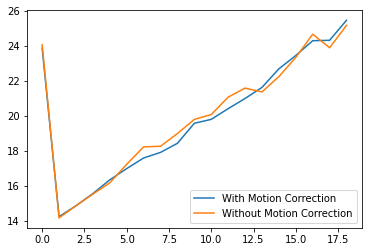

In [16]:
plt.plot(tot_motion)
plt.plot(tot_nomo)
plt.legend(['With Motion Correction', 'Without Motion Correction'])

In [13]:
import matplotlib.pyplot as plt

In [7]:
cnm_seeded.estimates.play_movie(images);

In [6]:
from ScanImageTiffReader import ScanImageTiffReader as si
import tifffile

In [5]:
fnames

['C:/caiman tests/stimtest2\\20200309_w21_1_e1_00001.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00003.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00004.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00005.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00006.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00007.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00008.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00009.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00010.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00011.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00012.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00013.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00014.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00015.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00016.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00017.tif',
 'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00018.tif

In [12]:
folder = 'E:/caiman tests/stimtest2/'
folder_tiffs = folder + '*.tif*'
fnames = glob(folder_tiffs)

tt = tic()
for f in fnames:
    t = tic()
    with si(f) as reader:
        data = reader.data()
    data_plane0 = data[slice(0,-1,6),:,100:412]
    tifffile.imsave(f.split('.')[0]+'_cut.tif', data_plane0)
    ptoc(t)
ptoc(tt)

Time elapsed: 0.3954 s
Time elapsed: 0.2137 s
Time elapsed: 0.1810 s
Time elapsed: 0.1805 s
Time elapsed: 0.1818 s
Time elapsed: 0.1887 s
Time elapsed: 0.1833 s
Time elapsed: 0.1820 s
Time elapsed: 0.1793 s
Time elapsed: 0.1908 s
Time elapsed: 0.1852 s
Time elapsed: 0.1797 s
Time elapsed: 0.1832 s
Time elapsed: 0.1803 s
Time elapsed: 0.2057 s
Time elapsed: 0.2032 s
Time elapsed: 0.1759 s
Time elapsed: 0.1816 s
Time elapsed: 0.2575 s
Time elapsed: 3.8328 s


3.8327503000036813

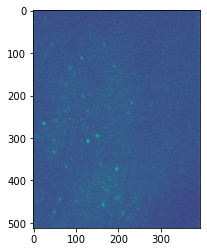

In [28]:
t = tic()
with si(fnames[0]) as reader:
    data = reader.data()
data_plane0 = data[slice(1,-1,6),:,60:452]
tifffile.imsave(f.split('.')[0]+'_cut.tif',data_plane0)
ptoc(t)

In [31]:
f

'C:/caiman tests/stimtest2\\20200309_w21_1_e1_00001.tif'

In [32]:
f.split('.')

['C:/caiman tests/stimtest2\\20200309_w21_1_e1_00001', 'tif']

In [36]:
cnm_seeded

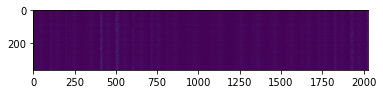

In [37]:
plt.imshow(cnm_seeded.estimates.C)

In [39]:
cnm_seeded.estimates.C.shape

(361, 2028)